In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt
from torch import nn

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs --port 6004

In [4]:
# load the training and test datasets
transform_train = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(size=32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) #Normalize to (-1,1)
])

transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) #Normalize to (-1,1)
])

trainset = torchvision.datasets.MNIST(root='data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.MNIST(root='data', train=False,download=True, transform=transform_eval)



In [5]:
#Define Dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
# We can use the exact same way to iterate over samples
for i, item in enumerate(trainloader):
    print('Batch {}'.format(i))
    image, label = item
    print(f"Datatype of Image: {type(image)}")
    print(f"Shape of the Image: {image.shape}")
    print(f"Label Values: {label}")

    if i+1 >= 1:
        break

Batch 0
Datatype of Image: <class 'torch.Tensor'>
Shape of the Image: torch.Size([64, 1, 28, 28])
Label Values: tensor([4, 5, 3, 1, 1, 7, 9, 5, 0, 7, 2, 4, 1, 6, 4, 2, 0, 5, 8, 6, 9, 6, 4, 4,
        3, 1, 5, 4, 2, 0, 0, 1, 8, 5, 8, 8, 4, 8, 4, 1, 0, 4, 3, 5, 9, 0, 8, 4,
        2, 1, 7, 7, 3, 9, 3, 5, 7, 3, 0, 1, 3, 3, 5, 1])


(3, 242, 242)
(242, 242, 3)


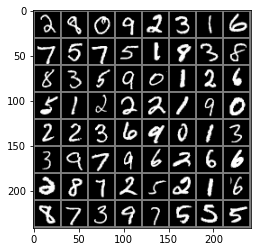

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalizec
    npimg = img.numpy()
    print(npimg.shape)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = CNNAutoencoder()
#model = model.to(device)

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
        m.bias.data.fill_(0.01)
        
model.apply(init_weights)

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [11]:
import torch.optim as optim

# Loss function
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(),  lr=0.001, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=0.001, 
                                 weight_decay=1e-5)

In [12]:
#Initialising the list for storing the loss and accuracy

training_loss = 0.0

for epoch in range(20):
    #Iterating through the minibatches of the data
    for i, data in enumerate(trainloader):
        
        # data is a tuple of (inputs, labels)
        image,_ = data
        #image = image.to(device)
        #y = y.to(device)
        
        # Reset the parameter gradients  for the current  minibatch iteration 
        optimizer.zero_grad()
    
        reconstruction = model(image)             # Perform a forward pass on the network with inputs
        loss = criterion(image, reconstruction) 
        loss.backward()             # Perform a backward pass to calculate the gradients
        optimizer.step()            # Optimise the network parameters with calculated gradients
        training_loss += loss.item()
    
    training_loss = training_loss/len(trainloader)
    print('Epoch: {}'.format(epoch),'\tTraining Loss: {:.4f}'.format(training_loss))

Epoch: 0 	Training Loss: 0.9411
Epoch: 1 	Training Loss: 0.9264
Epoch: 2 	Training Loss: 0.9264
Epoch: 3 	Training Loss: 0.9264
Epoch: 4 	Training Loss: 0.9263
Epoch: 5 	Training Loss: 0.8856
Epoch: 6 	Training Loss: 0.8472
Epoch: 7 	Training Loss: 0.8429
Epoch: 8 	Training Loss: 0.8411
Epoch: 9 	Training Loss: 0.8401
Epoch: 10 	Training Loss: 0.8395
Epoch: 11 	Training Loss: 0.8391
Epoch: 12 	Training Loss: 0.8389
Epoch: 13 	Training Loss: 0.8387
Epoch: 14 	Training Loss: 0.8386
Epoch: 15 	Training Loss: 0.8385
Epoch: 16 	Training Loss: 0.8385
Epoch: 17 	Training Loss: 0.8384
Epoch: 18 	Training Loss: 0.8384
Epoch: 19 	Training Loss: 0.8383


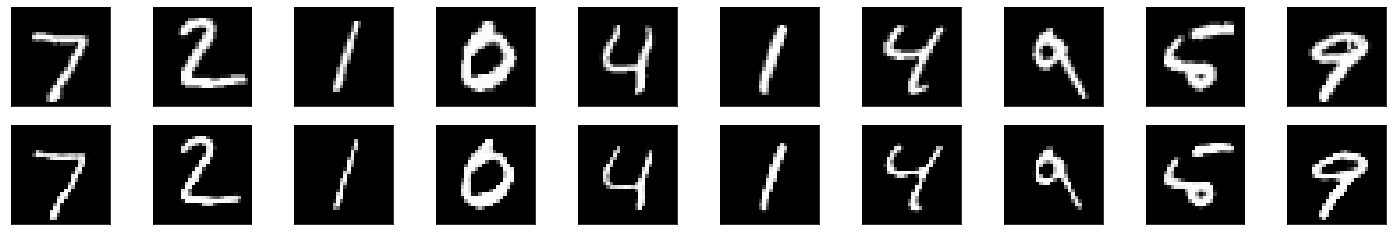

In [13]:
# Lets get batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
output = model(images)                     # get sample outputs
images = images.numpy()                    # prep images for display
output = output.view(64, 1, 28, 28)# resizing output
output = output.detach().numpy()           # use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)